# Árvore

## Antes da aula, alguns imports...

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

df = pd.read_csv('titanic.csv')

## Introdução Intuitiva - Árvore de Classificação

Da mesma forma que uma uma regressão logística, uma árvore de decisão representa uma função que toma como entrada uma série de atributos/*features* e retorna uma **decisão**: um valor de saída único.

Uma boa analogia é com os manuais de conserto de eletrodomésticos dos anos 90: se uma situação A acontecer, você seguirá os passos descritos pelo caminho A+; caso contrário, seguirá pelo caminho A-; cada caminho levará a diferentes verificações e, consequentemente, a diferentes conclusões.  chegando à sua conclusão por meio da execução de uma série de testes, em geral de "verdadeiro-falso". De forma simples e direta, é um conjunto de regras *if-then-else*, sendo de fácil interpretação e implementação.

Olhando para o exemplo da imagem a seguir, podemos ilustrar essa sequência: a raiz e cada nó interno na árvore correspondem ao testes de um atributo de entrada do modelo; as folhas representam a decisão para esse caminho que foi percorrido. 

![tree_nos](tree_nos.jpg)

Porém, os testes que ocorrem nos atributos não são aleatórios: devem ser entendidos como funções de custo que buscam otimizar a homogeneidade de suas subpopulações. Queremos fazer com que cada subpopulação de cada nó esteja cada vez mais homogêneo possível, até chegar a folha, usando para isso uma estratégia de dividir para conquistar. 

Vamos tomar como base uma amostra da tabela do Titanic:

In [5]:
df_amostra = df.sample(15, random_state = 1)
df_amostra

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S
623,624,0,3,"Hansen, Mr. Henry Damsgaard",male,21.0,0,0,350029,7.8542,NaN,S
148,149,0,2,"Navratil, Mr. Michel (""Louis M Hoffman"")",male,36.5,0,2,230080,26.0000,F2,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
34,35,0,1,"Meyer, Mr. Edgar Joseph",male,28.0,1,0,PC 17604,82.1708,NaN,C
241,242,1,3,"Murphy, Miss. Katherine ""Kate""",female,NaN,1,0,367230,15.5000,NaN,Q


In [6]:
# Quantidade de sobreviventes
df_amostra[df_amostra.Survived == 1].shape[0]

8

In [7]:
# Quantidade de NÃO sobreviventes
df_amostra[df_amostra.Survived == 0].shape

(7, 12)

**Para pensar:** intuitivamente, entre Sex e Parch, qual é a coluna que mais discrimina sobrevivência? Por quê?

In [8]:
df_amostra[df_amostra.Sex == 'male'].Survived.value_counts(1).sort_index()

0    0.857143
1    0.142857
Name: Survived, dtype: float64

In [9]:
df_amostra[df_amostra.Sex == 'female'].Survived.value_counts(1).sort_index()

0    0.125
1    0.875
Name: Survived, dtype: float64

In [10]:
df_amostra.Parch.value_counts()

0    13
2     2
Name: Parch, dtype: int64

In [11]:
df_amostra[df_amostra.Parch == 2].Survived.value_counts(1).sort_index()

0    0.5
1    0.5
Name: Survived, dtype: float64

In [12]:
df_amostra[df_amostra.Parch == 0].Survived.value_counts(1).sort_index()

0    0.461538
1    0.538462
Name: Survived, dtype: float64

## Entropia

Em árvores de decisão, estamos buscando separar as instâncias de forma a obter o máximo de homogeneidade possível nas folhas, observano a variável resposta. Para chegar nesse ponto, olhamos para o conjunto de dados, escolhemos uma variável e um limiar e dividimos em dois subconjuntos baseados nisso. A partir daí podemos repetir o passo anterior para cada subconjunto, e para cada subconjunto gerado nos subconjuntos, fazendo um processo recursivo até que tenhamos nosso conjunto de dados perfeitamente separado.

Porém, precisamos escolher um critério para escolher uma variável e limiar para separar em dois subconjuntos. Para isso, usaremos um conceito da Teoria da Informação chamado Entropia, que mede a aleatoriedade de uma variável aleatória, sendo dada por:

$$H(\textrm{VA}) = -\sum_i{p_i \times \log_{2}{p_i}}$$


Exemplificando com uma moeda $M_1$ não viciada, podemos citar dois eventos: 

- 1, cara, com probabilidade $p_1 = 0.5$
- 2, coroa, com probabilidade $p_2 = 0.5$

Dessa forma, a entropia $H(M_1)$ é:

$$H(M_1) = -(0.5 \times \log_{2}{0.5} + 0.5 \times \log_{2}{0.5}) = 1$$

Logo, a entropia é máxima (casos binário), significando que essa variável possui um alto nível de aleatoriedade.

Podemos verificar esse pico ao pensar em moedas viciadas com probabilidades do evento 1 linearmente espaçadas entre 0 e 1:

In [13]:
p = np.linspace(0.001, 0.999, 99)
n = 1 - p
entropia = -(p*np.log2(p) + n*np.log2(n))

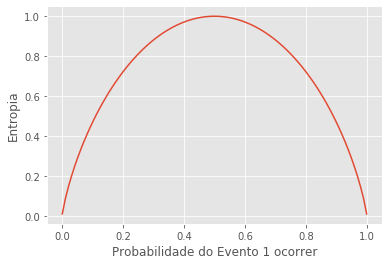

In [14]:
plt.plot(p, entropia)
plt.xlabel('Probabilidade do Evento 1 ocorrer')
plt.ylabel('Entropia')

plt.show()

Qual a entropia da variável Pclass?

In [15]:
df_amostra.Pclass.value_counts(1)

3    0.466667
2    0.266667
1    0.266667
Name: Pclass, dtype: float64

In [16]:
-(0.2667*np.log2(0.2667) + 0.2667*np.log2(0.2667) + 0.4667*np.log2(0.4667))

1.5301444653112746

In [17]:
df_amostra.Embarked.value_counts()

S    11
Q     3
C     1
Name: Embarked, dtype: int64

**Para pensar:** Qual que é a entropia da variável Survived?

In [18]:
df_amostra.Survived.value_counts(1)

1    0.533333
0    0.466667
Name: Survived, dtype: float64

In [19]:
def entropia_binaria(p):
    n = 1 - p
    return -(p*np.log2(p) + n*np.log2(n))

In [29]:
entropia_binaria(df_amostra.Survived.value_counts(1)[0])

0.9967916319816366

In [30]:
conj1 = df_amostra[df_amostra.Sex == 'male']
conj2 = df_amostra[df_amostra.Sex == 'female']

print('Entropia do Conjunto 1: ', entropia_binaria(conj1.Survived.value_counts(1)[0]))
print('Entropia do Conjunto 2: ', entropia_binaria(conj2.Survived.value_counts(1)[0]))

Entropia do Conjunto 1:  0.5916727785823275
Entropia do Conjunto 2:  0.5435644431995964


In [31]:
conj1 = df_amostra[df_amostra.Parch == 0]
conj2 = df_amostra[df_amostra.Parch == 2]

print('Entropia do Conjunto 1: ', entropia_binaria(conj1.Survived.value_counts(1)[0]))
print('Entropia do Conjunto 2: ', entropia_binaria(conj2.Survived.value_counts(1)[0]))

Entropia do Conjunto 1:  0.9957274520849255
Entropia do Conjunto 2:  1.0


In [32]:
conj1 = df_amostra[df_amostra.Pclass == 3]
conj2 = df_amostra[df_amostra.Pclass != 3]

print('Entropia do Conjunto 1: ', entropia_binaria(conj1.Survived.value_counts(1)[0]))
print('Entropia do Conjunto 2: ', entropia_binaria(conj2.Survived.value_counts(1)[0]))

Entropia do Conjunto 1:  0.9852281360342515
Entropia do Conjunto 2:  0.954434002924965


In [33]:
Entropia da Quebra:
e1*qe1/te + e2*qe2/te

SyntaxError: invalid syntax (<ipython-input-33-30ce62f12c59>, line 1)

In [34]:
0.5*3/(3 + 47) + 0.9*47/(3 + 47)

0.8760000000000001

In [35]:
0.6*28/(28 + 22) + 0.9*22/(28 + 22)

0.732

Formalizando matematicamente:
    
Em casos binários, no qual uma variável aleatória assume o valor 0 ou 1, podemos escrever a entropia como

$$H(\textrm{VA}) = B\left( \frac{p}{p + n}\right)= -\big[p \times \log_{2}{p} + (1 - p) \times \log_{2}(1 - p)\big]$$

O que queremos obter com a divisão do conjunto de dados são subconjuntos que diminuam ao máximo a aleatoriedade da variável resposta do conjunto original. Logo, para cada atributo do conjunto de dados, queremos calcular o **Ganho de Informação** que mede a redução na entropia das partições obtidas de acordo os valores desse atributo. Isso é dado pela diferença entre a entropia do conjunto de exemplos original e a soma ponderada da entropia das partições, sendo a construção da árvore orientada pelo objetivo de reduzir a entropia.

Ou seja, um atributo $A$ com $d$ valores possíveis para ele gera $S$ subconjuntos $S_1, S_2, ..., S_d$. Cada subconjunto $S_k$ possui $p_k$ exemplos positivos e $n_k$ exemplos negativos, nos dando uma entropia de $B\left( \frac{p_k}{p_k + n_k}\right)$. Ponderando pela quantidade de exemplos dos subconjuntos, temos um conteúdo de informação esperado do atributo $A_i$ de

$$E(A_i) = \sum_i{\frac{p_k + n_k}{p + k} B\left( \frac{p_k}{p_k + n_k}\right)}$$.

Dessa forma, o Ganho de Informação do atributo $A_i$ é a redução na entropia do estado anterior para o estado posterior, na forma

$$\textrm{Ganho}(A_i) =  B\left( \frac{p}{p + n}\right) - E(A_i)$$






**Para pensar:** Qual o ganho de informação de utilizar as variáveveis Sex e Parch no dataframe de amostra?

In [36]:
def entropia_binaria(p):
    n = 1 - p
    return -(p*np.log2(p) + n*np.log2(n))

In [38]:
ent_inicial = entropia_binaria(df_amostra.Survived.value_counts(1)[0])

In [39]:
conj1 = df_amostra[df_amostra.Sex == 'male']
conj2 = df_amostra[df_amostra.Sex == 'female']

conj1_e = entropia_binaria(conj1.Survived.value_counts(1)[0])
conj2_e = entropia_binaria(conj2.Survived.value_counts(1)[0])

In [40]:
conj1_e

0.5916727785823275

In [41]:
conj2_e

0.5435644431995964

In [42]:
conj1_t = conj1.shape[0]
conj2_t = conj2.shape[0]
total = conj1_t + conj2_t

In [43]:
conj1_t, conj2_t

(7, 8)

In [44]:
ent_sex = conj1_e*conj1_t/total + conj2_e*conj2_t/total

In [45]:
ent_inicial - ent_sex

0.430776632270099

In [46]:
conj1 = df_amostra[df_amostra.Parch == 0]
conj2 = df_amostra[df_amostra.Parch != 0]

conj1_e = entropia_binaria(conj1.Survived.value_counts(1)[0])
conj2_e = entropia_binaria(conj2.Survived.value_counts(1)[0])

conj1_t = conj1.shape[0]
conj2_t = conj2.shape[0]
total = conj1_t + conj2_t

ent_parch = conj1_e*conj1_t/total + conj2_e*conj2_t/total

ent_inicial - ent_parch

0.0004945068413678699

In [47]:
def categoriza_fare(x):
    if x < 10:
        return 'baixo'
    elif x < 30:
        return 'medio'
    else:
        return 'alto'

df_amostra['fare_categorizado'] = df_amostra.Fare.apply(categoriza_fare)
df_amostra.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_categorizado
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S,medio
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S,baixo
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S,medio
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q,baixo
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S,medio


In [48]:
df_amostra.fare_categorizado.value_counts(1)

medio    0.4
baixo    0.4
alto     0.2
Name: fare_categorizado, dtype: float64

In [49]:

conj1 = df_amostra[df_amostra.fare_categorizado == 0]
conj2 = df_amostra[df_amostra.fare_categorizado != 0]

conj1_e = entropia_binaria(conj1.Survived.value_counts(1)[0])
conj2_e = entropia_binaria(conj2.Survived.value_counts(1)[0])

conj1_t = conj1.shape[0]
conj2_t = conj2.shape[0]
total = conj1_t + conj2_t

ent_parch = conj1_e*conj1_t/total + conj2_e*conj2_t/total

ent_inicial - ent_parch

IndexError: index out of bounds

In [22]:
def ganho_informacao(df, coluna, seq_poss):
    
    conj = [df[df[coluna] == i] for i in seq_poss]
    
    return ent

In [23]:
vc = ganho_informacao(df_amostra, 'fare_categorizado', ['alto', 'medio', 'baixo'])

KeyError: 'fare_categorizado'

In [50]:
vc[0]

NameError: name 'vc' is not defined

In [51]:
vc[1]

NameError: name 'vc' is not defined

In [52]:
vc[2]

NameError: name 'vc' is not defined

In [53]:
def ganho_informacao(df, coluna, seq_poss):
    
    conj = [df[df[coluna] == i] for i in seq_poss]
    ent = [entropia_binaria(i['Survived'].value_counts(1)[0]) for i in conj]
    
    return ent

In [54]:
ganho_informacao(df_amostra, 'fare_categorizado', ['alto', 'medio', 'baixo'])

[0.9182958340544896, 0.6500224216483541, 0.9182958340544896]

In [55]:
def ganho_informacao(df, coluna, var_resposta, seq_poss = None):
    
    if seq_poss == None:
        seq_poss = df[coluna].unique()
    
    ent_inicial = entropia_binaria(df[var_resposta].value_counts(1)[0])
    
    conj = [df[df[coluna] == i] for i in seq_poss]
    ent = [entropia_binaria(i[var_resposta].value_counts(1)[0]) for i in conj]
    n_elem = [i.shape[0] for i in conj]
    
    total = sum(n_elem)
    
    ent_atr = 0
    for i in range(len(conj)):
        ent_atr += ent[i]*n_elem[i]/total
    
    return ent_inicial - ent_atr

In [56]:
ganho_informacao(df_amostra, 'fare_categorizado', 'Survived', ['alto', 'medio', 'baixo'])

0.18580516288960114

In [57]:
ganho_informacao(df_amostra, 'fare_categorizado', 'Survived')

0.18580516288960125

In [58]:
ganho_informacao(df_amostra, 'Sex', 'Survived', ['male', 'female'])

0.430776632270099

In [ ]:
ganho_informacao(df_amostra, 'Sex', 'Survived')

In [ ]:
ganho_informacao(df_amostra, 'Parch', 'Survived', [0, 2])

In [ ]:
ganho_informacao(df_amostra, 'Parch', 'Survived')

In [ ]:
ganho_informacao(df_amostra, 'SibSp', 'Survived')

In [24]:
df_amostra.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
862,863,1,1,"Swift, Mrs. Frederick Joel (Margaret Welles Ba...",female,48.0,0,0,17466,25.9292,D17,S
223,224,0,3,"Nenkoff, Mr. Christo",male,NaN,0,0,349234,7.8958,NaN,S
84,85,1,2,"Ilett, Miss. Bertha",female,17.0,0,0,SO/C 14885,10.5000,NaN,S
680,681,0,3,"Peters, Miss. Katie",female,NaN,0,0,330935,8.1375,NaN,Q
535,536,1,2,"Hart, Miss. Eva Miriam",female,7.0,0,2,F.C.C. 13529,26.2500,NaN,S


In [25]:
df_amostra.SibSp.value_counts()

0    12
1     3
Name: SibSp, dtype: int64

In [26]:
df_amostra.Parch.value_counts()

0    13
2     2
Name: Parch, dtype: int64

In [27]:
df_amostra.Age.value_counts(dropna = False).sort_index()

7.0     1
17.0    1
21.0    1
25.0    1
26.0    1
28.0    1
35.0    1
36.5    1
48.0    1
54.0    1
NaN     5
Name: Age, dtype: int64

In [28]:
colunas_a_testar = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'fare_categorizado']
colunas_gi = {}

for col in colunas_a_testar:
    colunas_gi[col] = ganho_informacao(df_amostra, col, 'Survived')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


NameError: name 'ent' is not defined

In [ ]:
colunas_gi